### Calculate neutral density in OM4 output
#### Development notebook - ready to archive
Using pygamma package from Eric Firing `~/packages/gamma_n_efiring`.   

Actual calculation can be found in `projects/so_decadal_variability/scripts/calc_gamma.py`.  

In [1]:
import xarray as xr
import numpy as np
from pygamma import gamma_n
import gsw
import wmt_bgc.basic as wmt
import matplotlib.pyplot as plt
import glob
import re
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

ImportError: libgfortran.so.4: cannot open shared object file: No such file or directory

In [ ]:
g_attrs = {'long_name':'Neutral density (gamma_n) from Jackett and McDougall (1997)',
           'units':'kgm-3',
           'standard_name':'gamma_n'}

In [ ]:
def _gamma_n_4D(S,T,p,lon,lat,verbose=False):
    ni,nj,nk,nt = S.shape
    g_vals = np.empty(shape=(ni,nj,nk,nt))
    for t in range(nt):
        for j in range(nj):
            if verbose:
                if np.mod(j,100)==0:
                    print('time-index = '+str(t)+'; y-index = '+str(j))
            g_vals[:,j,:,t],_,_ = gamma_n(S[:,j,:,t],
                                          T[:,j,:,t],
                                          p[:,j,:,t],
                                          lon[:,j],
                                          lat[:,j])
    return g_vals

In [15]:
%%time
# Load data
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filename = pp+'.*.'
files = glob.glob(rootdir+pp+localdir+filename+'so.nc')
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')[['geolon','geolat']]

outdir = '/archive/gam/so_decadal_variability/OM4p25_JRA55do1.4_0netfw_cycle6/'

# Reconfigure longitude to be 0 to 360
grid['geolon'] = grid['geolon'].where(grid['geolon']>0,grid['geolon']+360)
# Load depth levels
grid['z_l']=xr.open_dataset(files[0])['z_l']
# Calculate pressure
grid['p'] = wmt.gsw_p_from_z(-1*grid['z_l'],grid['geolat'])

for file in files:
    # Get the year range
    m = re.search(localdir+pp+'.(.+?).so.nc', file)
    print(m.group(1))
    inpath = rootdir+pp+localdir+pp+'.'+m.group(1)+'.'
    outpath = outdir+pp+'/'+pp+'.'+m.group(1)+'.'
    
    ds = xr.Dataset()
    ds['thetao'] = xr.open_dataset(inpath+'thetao.nc')['thetao']
    ds['so'] = xr.open_dataset(inpath+'so.nc')['so']
    
    select = {'xh':slice(500,510),'yh':slice(200,210),'z_l':slice(0,5),'time':slice(0,2)}
    dsnow = ds.transpose().isel(select)
    gridnow = grid.transpose().isel(take(3,select.items()))

    g_vals = _gamma_n_4D(dsnow['so'],
                         dsnow['thetao'],
                         gridnow['p'].broadcast_like(dsnow['so']),
                         gridnow['geolon'],
                         gridnow['geolat'],
                         verbose=True)
    
    g = dsnow['so'].copy(data=g_vals).assign_attrs(g_attrs).transpose()
    g.name='gamma_n'
    g.to_netcdf(outpath+'gamma_n.nc')

1998-2002
time-index = 0; y-index = 0
time-index = 1; y-index = 0
2003-2007
time-index = 0; y-index = 0
time-index = 1; y-index = 0
2008-2012
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1968-1972
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1958-1962
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1963-1967
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1978-1982
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1983-1987
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1988-1992
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1993-1997
time-index = 0; y-index = 0
time-index = 1; y-index = 0
1973-1977
time-index = 0; y-index = 0
time-index = 1; y-index = 0
2013-2017
time-index = 0; y-index = 0
time-index = 1; y-index = 0
CPU times: user 8.29 s, sys: 405 ms, total: 8.7 s
Wall time: 16 s


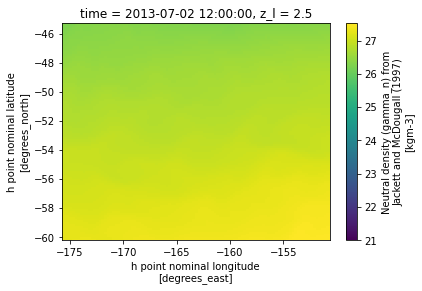

In [10]:
g.isel(z_l=0,time=0).plot(vmin=21)

In [203]:
j

9

In [195]:
select = {'xh':slice(100,650),'yh':slice(150,250),'z_l':slice(0,-1),'time':slice(0,4)}
dsnow = ds.transpose('xh','yh','z_l','time').isel(select)
gridnow = grid.transpose('xh','yh','z_l').isel(take(3,select.items()))

g_vals = _gamma_n_4D(dsnow['so'],
                     dsnow['thetao'],
                     gridnow['p'].broadcast_like(dsnow['so']),
                     gridnow['geolon'],
                     gridnow['geolat'],
                     verbose=True)

g = dsnow['so'].copy(data=g_vals).assign_attrs(g_attrs)

time-index = 0
time-index = 1


In [196]:
g[0,0,0,1]

<xarray.DataArray 'so' ()>
array(27.79776175)
Coordinates:
    time     object 2014-07-02 12:00:00
    xh       float64 -274.9
    yh       float64 -65.81
    z_l      float64 2.5
Attributes:
    long_name:      Neutral density (gamma_n) from Jackett and McDougall (1997)
    units:          kgm-3
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  gamma_n

In [197]:
gamma_n(dsnow['so'][0,0,0,1].values,
        dsnow['thetao'][0,0,0,1].values,
        gridnow['p'][0,0,0].values,
        gridnow['geolon'][0,0].values,
        gridnow['geolat'][0,0].values)

(27.797761749448654, 0.0017899685507591007, 0.005591509604342709)

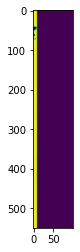

In [200]:
plt.imshow(g.isel(time=0,z_l=0))

In [28]:
# Load the data
# (from restart)
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filename = pp+'.201*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename)
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')

In [29]:
dsnow = ds.transpose('xh','yh','z_l','time','nv','xq','yq','z_i').isel(xh=slice(100,110),yh=slice(100,110),z_l=slice(0,5))
gridnow = grid.transpose('xh','yh','xq','yq').isel(xh=slice(100,110),yh=slice(100,110))

S = dsnow['so'].values
T = dsnow['thetao'].values
p = (wmt.gsw_p_from_z(-1*dsnow['z_l'],gridnow['geolat']).transpose('xh','yh','z_l')*xr.ones_like(dsnow['time'])).values
lon = gridnow['geolon'].where(gridnow['geolon']>0,gridnow['geolon']+360).values
lat = gridnow['geolat'].values

In [30]:
def _calc_gamma(S,T,p,lon,lat):
    gamma = np.zeros(shape=S.shape)
    for t in range(len(S[0,0,0,:])):
        print('time-index = '+str(t))
        for j in range(len(S[0,:,0,t])):
            if np.mod(j,100)==0:
                print('y-index = '+str(j))
            gamma[:,j,:,t],dg_hi,dg_lo = gamma_n(S[:,j,:,t],T[:,j,:,t],p[:,j,:,t],lon[:,j],lat[:,j])
    return gamma

In [31]:
gamma_vals = _calc_gamma(S,T,p,lon,lat)

time-index = 0
y-index = 0
time-index = 1
y-index = 0
time-index = 2
y-index = 0
time-index = 3
y-index = 0
time-index = 4
y-index = 0


In [46]:
gamma = dsnow['so'].copy(data=gamma_vals)
gamma.name='gamma_n'
gamma.assign_attrs({'long_name':'Neutral density (gamma_n) from Jackett and McDougall (1997)',
                    'units':'kgm-3',
                    'standard_name':'gamma_n'});

In [48]:
gamma.to_netcdf('/archive/gam/so_decadal_variability/OM4p25_JRA55do1.4_0netfw_cycle6/'+pp+'/gamma_n.nc')

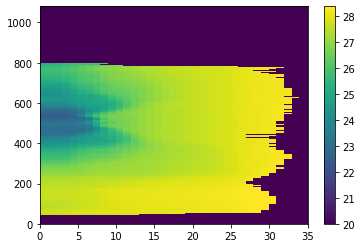

In [100]:
im = plt.pcolormesh(gamma[600,:,:],vmin=20)
plt.colorbar(im)

In [20]:
def xr_gamma(s,t,p,lon,lat):
    return xr.apply_ufunc(pygamma.gamma_n,
                         s,t,p,lon,lat,
                         dask='parallelized',output_dtypes=[s.dtype])

In [44]:
gamma.attrs

{'long_name': 'Sea Water Salinity',
 'units': 'psu',
 'cell_methods': 'area:mean z_l:mean yh:mean xh:mean time: mean',
 'cell_measures': 'volume: volcello area: areacello',
 'time_avg_info': 'average_T1,average_T2,average_DT',
 'standard_name': 'sea_water_salinity'}

In [41]:
gamma

<xarray.DataArray 'gamma_n' (xh: 10, yh: 10, z_l: 5, time: 5)>
array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        ...,

...

        ...,

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]]])
Coordinates:
  * time     (time) object 2013-07-02 12:00:00 ... 2017-07-02 12:00:00
  * xh       (xh) float64 -274.9 -274.7 -274.4 -274.2 ... -273.2 -272.9 -272.7
  * yh       (yh) float64 -70.86 -70.76 -70.66 -70.56 ... -70.15 -70.05 -69.95
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 51.25
Attributes:
    long_name:      Sea Water Salinity
    units:          psu
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity